<a href="https://colab.research.google.com/github/Lacave91/Project-CNN/blob/main/transfer_learning_winner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Model 5: Transfer learning (VGG16):**
We are building a new model base on VGG16 to predict animals.


In [13]:
import os
import zipfile
from google.colab import drive

# 📌 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 📌 Step 2: Define Paths
animals_zip_path = "/content/drive/MyDrive/animals10.zip"  # Training + validation (90%)
holdout_zip_path = "/content/drive/MyDrive/holdout.zip"  # Holdout set (10%)

animals_extract_to = "/content/Animals-10/"
holdout_extract_to = "/content/Holdout-10/"

# 📌 Step 3: Extract the ZIP Files
if not os.path.exists(animals_extract_to):
    with zipfile.ZipFile(animals_zip_path, 'r') as zip_ref:
        zip_ref.extractall(animals_extract_to)
    print("✅ Extracted training dataset.")

if not os.path.exists(holdout_extract_to):
    with zipfile.ZipFile(holdout_zip_path, 'r') as zip_ref:
        zip_ref.extractall(holdout_extract_to)
    print("✅ Extracted holdout dataset.")

# 📌 Step 4: Fix Dataset Paths (Point to `raw-img/`)
animals_dataset_path = "/content/Animals-10/animals10/raw-img/"
holdout_dataset_path = "/content/Holdout-10/holdout/raw-img/"

# 📌 Step 5: Check Folder Structure
print("📂 Training Dataset Categories:", os.listdir(animals_dataset_path))
print("📂 Holdout Dataset Categories:", os.listdir(holdout_dataset_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Training Dataset Categories: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']
📂 Holdout Dataset Categories: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']


**Check the folder structures:**

In [14]:
# List class folders
print("📂 Classes in Training Dataset:", os.listdir(animals_dataset_path))

# Print the class folders inside the holdout dataset
if os.path.exists(holdout_dataset_path):
    print("📂 Classes in Prediction (Holdout) Dataset:", os.listdir(holdout_dataset_path))
else:
    print("❌ Holdout dataset path not found:", holdout_dataset_path)


📂 Classes in Training Dataset: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']
📂 Classes in Prediction (Holdout) Dataset: ['sheep', 'spider', 'squirrel', 'cow', '.DS_Store', 'elephant', 'cat', 'dog', 'butterfly', 'chicken', 'horse']


## **Load Dataset:**
Normalize images, rescale and resize, train/validation split, one-hot encode is handled by imageDataGenerator.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # Ensure consistent split
)

# Only normalization for validation (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Dataset successfully loaded!")

print("Dataset successfully loaded!")


Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.
Dataset successfully loaded!
Dataset successfully loaded!


## **Plot 5 random images**

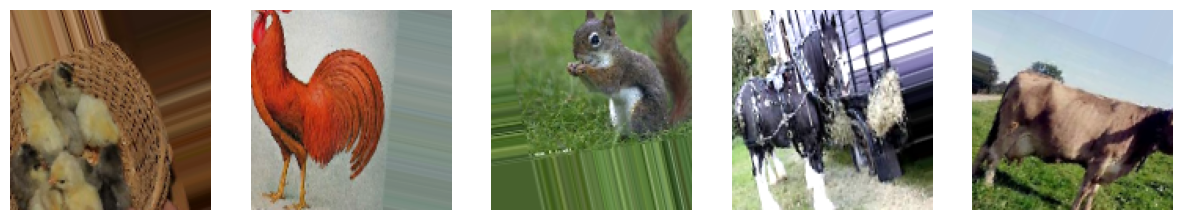

In [16]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
plt.show()

## **Model architecture:**
*   Load VGG16 model from keras.
*   Freeze the weights on all the layers but unfreeze the last 10 layers to allow fine-tuning.
*   Add 3 Dense layers to extract high-level features into the final predictions, plus the softmax classification dense layer at the end.
*   Adds L2 regularization (penalizes large weights to prevent overfitting).
*   Dropout 0.4.(Drops 40% of neurons randomly during training.)








In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

# Load the pre-trained model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the entire convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Check the trainable state of each layer
for i, layer in enumerate(base_model.layers):
    print(f"{i}. {layer.name}: {layer.trainable}")

# Create a new model on top of VGG16
model = Sequential()

# Add VGG16 base model
model.add(base_model)

# Add the new classification layers
model.add(Flatten())


model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(BatchNormalization())
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))



0. input_layer_2: False
1. block1_conv1: False
2. block1_conv2: False
3. block1_pool: False
4. block2_conv1: False
5. block2_conv2: False
6. block2_pool: False
7. block3_conv1: False
8. block3_conv2: False
9. block3_conv3: True
10. block3_pool: True
11. block4_conv1: True
12. block4_conv2: True
13. block4_conv3: True
14. block4_pool: True
15. block5_conv1: True
16. block5_conv2: True
17. block5_conv3: True
18. block5_pool: True


## **Compile and Train the model:**
Callbacks:
*   Early stopping: In case here is no improvement for 5 consecutive epochs.
*   Reduce_lr: Reduces the learning rate by a factor of 0.5 when the validation loss (val_loss) does not improve for 4 consecutive epochs.

We use Adam as optimiser but fine-tuning the learning rate(revents the model from "forgetting" the knowledge it has learned during pretraining (from VGG16) while still allowing it to learn task-specific features).
30 epochs with early stopping.


In [18]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

# Compile the model
fine_tune_lr = Adam(learning_rate=5e-5)
model.compile(loss='categorical_crossentropy', optimizer=fine_tune_lr, metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 117s 184ms/step - accuracy: 0.1388 - loss: 4.1839 - val_accuracy: 0.2780 - val_loss: 3.3163 - learning_rate: 5.0000e-05
Epoch 2/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - accuracy: 0.2245 - loss: 3.6351 - val_accuracy: 0.4220 - val_loss: 2.7078 - learning_rate: 5.0000e-05
Epoch 3/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 175ms/step - accuracy: 0.3091 - loss: 3.2170 - val_accuracy: 0.2854 - val_loss: 3.3055 - learning_rate: 5.0000e-05
Epoch 4/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - accuracy: 0.3355 - loss: 3.0378 - val_accuracy: 0.4511 - val_loss: 2.6482 - learning_rate: 5.0000e-05
Epoch 5/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 175ms/step - accuracy: 0.4751 - loss: 2.5433 - val_accuracy: 0.6188 - val_loss: 2.0284 - learning_rate: 5.0000e-05
Epoch 6/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 104s 177ms/step - accuracy: 0.5621 - loss: 2.2374 - val_accuracy: 0.7120 - val_loss: 1.8200 - learning_rate: 5.0000e-05
Epoch 7/30
590/590 ━━━━━━━━━━━━━━━━━━━━ 

Define Model

## **Evaluate Model Performance on Validation Set (NOT on Holdout)**

148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9183 - loss: 0.5824
Validation Accuracy: 91.46%
Validation Loss: 0.6035
Training Accuracy: 93.77%
Training Loss: 0.4821


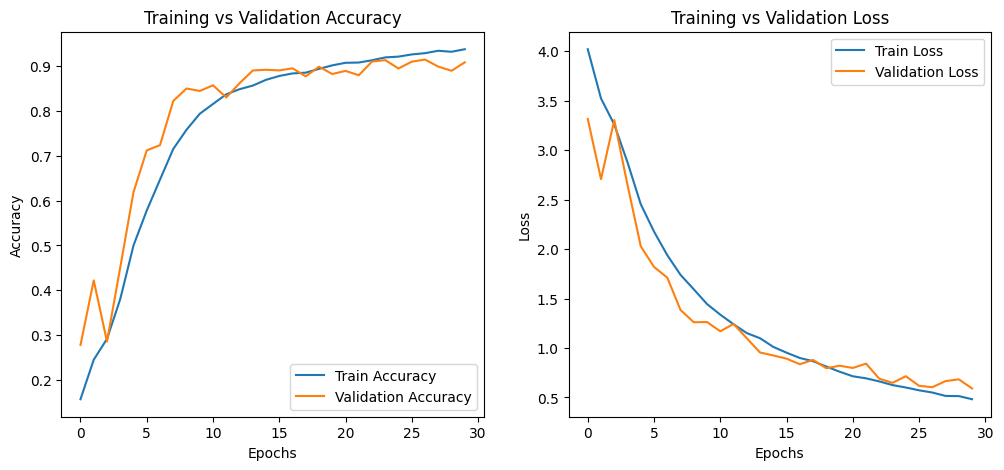

In [19]:
# Evaluate the Model
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Get final training accuracy & loss
train_accuracy = history.history['accuracy'][-1]  # Last epoch's accuracy
train_loss = history.history['loss'][-1]  # Last epoch's loss

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.show()

## **Predict on validation set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

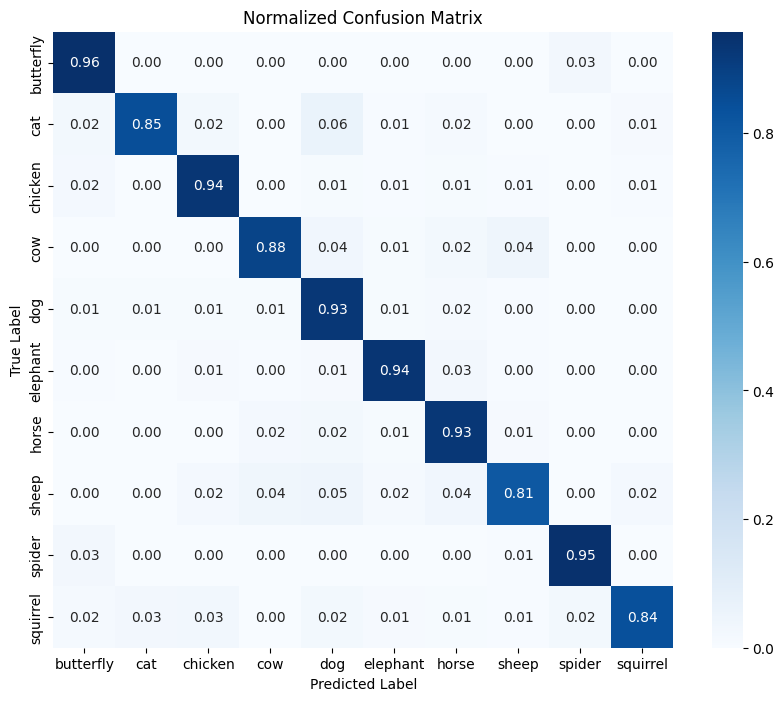

              precision    recall  f1-score   support

   butterfly       0.87      0.96      0.91       380
         cat       0.91      0.85      0.88       300
     chicken       0.93      0.94      0.93       557
         cow       0.90      0.88      0.89       336
         dog       0.92      0.93      0.92       875
    elephant       0.88      0.94      0.91       260
       horse       0.88      0.93      0.90       472
       sheep       0.87      0.81      0.84       327
      spider       0.97      0.95      0.96       867
    squirrel       0.94      0.84      0.89       335

    accuracy                           0.91      4709
   macro avg       0.91      0.90      0.90      4709
weighted avg       0.92      0.91      0.91      4709



In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to hold true and predicted labels
y_true = []
y_pred = []

# Get class labels from the generator
class_labels = list(val_generator.class_indices.keys())

# Predict on the entire validation set
for images, labels in val_generator:
    # Get predictions for the batch
    predictions = model.predict(images)

    # Convert one-hot labels to class indices
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

    # Stop when all validation samples are processed
    if len(y_true) >= val_generator.samples:
        break

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(y_true, y_pred, target_names=class_labels))



## **Predict on Holdout Set (No Evaluation, Only Predictions)**


✅ Making Predictions on Holdout Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━

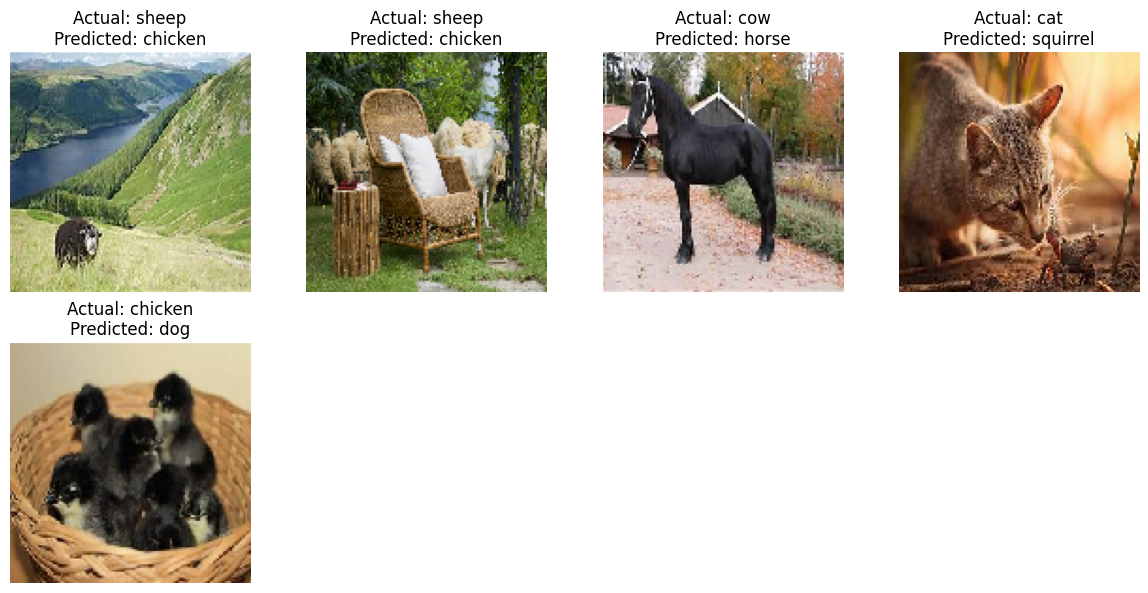

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

print("\n✅ Making Predictions on Holdout Set...")

class_labels = list(train_generator.class_indices.keys())

misclassified_images = []  # Store misclassified images

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)

    if os.path.isdir(class_folder):
        image_files = os.listdir(class_folder)

        for img_file in image_files[:5]:  # Predict on first 5 images
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Ignore `.DS_Store`
                img_path = os.path.join(class_folder, img_file)

                # Load & Preprocess Image
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Normalize

                # Make Prediction
                prediction = model.predict(img_array)
                predicted_class = np.argmax(prediction)
                predicted_label = class_labels[predicted_class]

                # Check if misclassified
                if predicted_label != class_name:
                    misclassified_images.append((img_path, class_name, predicted_label))

#Display Misclassified Images
if misclassified_images:
    print(f"\n❌ Found {len(misclassified_images)} Misclassified Images. Displaying...")

    plt.figure(figsize=(12, 6))
    for i, (img_path, actual, predicted) in enumerate(misclassified_images[:8]):  # Show first 8 misclassified images
        img = image.load_img(img_path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassified images found in the first few samples!")
